<a href="https://www.kaggle.com/code/sushanttwayana/finaldc-sdss?scriptVersionId=193504582" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Libraries

In [1]:
import torch
import torch.nn as nn
# import torchvision.utils as vutils
# from torch.autograd import Variable
# from torch.utils.data import DataLoader

# from data_util import Text2ImageDataset
# from utils import process_caption, weights_init
# from models.char_cnn_rnn_model import CharCNNRNN
# from models.dcgan_model import Generator, Discriminator

import os
import time
import imageio
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Data Utils 

In [2]:
# Copied from https://github.com/aelnouby/Text-to-Image-Synthesis

import os
import io
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import pdb
from PIL import Image
import torch
from torch.autograd import Variable
import pdb
import torch.nn.functional as F

class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        # pdb.set_trace()

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embedding'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:
            
            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embedding']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

# Utilis 

In [3]:
import torch

def process_caption(caption, max_caption_length=200, alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "):
    """
    Converts a caption string to a tensor of one-hot encoded vectors based on the given alphabet.

    Args:
        caption (str): The input caption to be converted to one-hot encoded vectors.
        max_caption_length (int): The maximum length of the output label sequence. If the caption is longer, it will be truncated.
        alphabet (str, optional): The alphabet used to map characters to numeric labels and define the length of the one-hot vectors. Default is a combination of lowercase letters, numbers, and common punctuation marks.

    Returns:
        torch.Tensor: A tensor containing the one-hot encoded vectors for the caption.
    """
    # Convert the caption to lowercase for case-insensitivity
    caption = caption.lower()

    # Create a mapping from characters in the alphabet to numeric labels
    alpha_to_num = {k: v + 1 for k, v in zip(alphabet, range(len(alphabet)))}

    # Initialize the output tensor with zeros and set the data type to long
    labels = torch.zeros(max_caption_length).long()

    # Determine the maximum number of characters to process from the caption
    max_i = min(max_caption_length, len(caption))

    # Convert each character in the caption to its corresponding numeric label
    for i in range(max_i):
        # If the character is not in the alphabet, use the numeric label for space (' ')
        labels[i] = alpha_to_num.get(caption[i], alpha_to_num[' '])
    
    labels = labels.unsqueeze(1)
    
    # Convert the numeric labels to one-hot encoded vectors
    # Initialize a tensor of zeros with the shape (sequence length, alphabet length + 1) and scatter ones based on the labels
    one_hot = torch.zeros(labels.size(0), len(alphabet) + 1).scatter_(1, labels, 1.)
    
    # Remove the column corresponding to the numeric label 0 (used for padding)
    one_hot = one_hot[:, 1:]
    
    # Permute the tensor to have the sequence length as the first dimension
    one_hot = one_hot.permute(1, 0)

    return one_hot

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Generator architecture
        model = []
        model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
        model += self._create_layer(512, 256, 4, stride=2, padding=1)
        model += self._create_layer(256, 128, 4, stride=2, padding=1)
        model += self._create_layer(128, 64, 4, stride=2, padding=1)
        model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
        layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
        if output:
            layers.append(nn.Tanh())  # Tanh activation for the output layer
        else:
            layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
        return layers

    def forward(self, noise, text):
        # Apply text embedding to the input text
        text = self.text_embedding(text)
        text = text.view(text.shape[0], text.shape[1], 1, 1)  # Reshape text to (batch_size, embed_out_dim, 1, 1)

        # Concatenate text with noise
        z = torch.cat([text, noise], 1)  # Concatenate along channel dimension

        return self.model(z)


In [5]:
# import torch
# import torch.nn as nn

# # The Generator model
# class Generator(nn.Module):
#     def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
#         super(Generator, self).__init__()
#         self.channels = channels
#         self.noise_dim = noise_dim
#         self.embed_dim = embed_dim
#         self.embed_out_dim = embed_out_dim

#         # Text embedding layers
# #         self.text_embedding = nn.Sequential(
# #             nn.Linear(self.embed_dim, self.embed_out_dim),
# #             nn.BatchNorm1d(self.embed_out_dim),
# #             nn.LeakyReLU(0.2, inplace=True)
# #         )
#         self.text_embedding = nn.Sequential(
#     nn.Linear(self.embed_dim, self.embed_out_dim),
#     nn.BatchNorm1d(self.embed_out_dim),
#     nn.LeakyReLU(0.2, inplace=True)
# )


#         # Generator architecture
#         model = []
#         model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
#         model += self._create_layer(512, 256, 4, stride=2, padding=1)
#         model += self._create_layer(256, 128, 4, stride=2, padding=1)
#         model += self._create_layer(128, 64, 4, stride=2, padding=1)
#         model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

#         self.model = nn.Sequential(*model)

#     def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
#         layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
#         if output:
#             layers.append(nn.Tanh())  # Tanh activation for the output layer
#         else:
#             layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
#         return layers

#     def forward(self, noise, text):
#         # Apply text embedding to the input text
#         text = self.text_embedding(text)
#         print("Text embedding shape:", text.shape)

#         # Reshape text to match the generator input size
#         text = text.view(text.shape[0], text.shape[1], 1, 1)
#         print("Reshaped text shape:", text.shape)

#         # Concatenate text with noise
#         z = torch.cat([text, noise], 1)
#         print("Concatenated tensor shape:", z.shape)

#         return self.model(z)



# # The Embedding model
# class Embedding(nn.Module):
#     def __init__(self, size_in, size_out):
#         super(Embedding, self).__init__()
        
#         self.text_embedding = nn.Sequential(
#             nn.Linear(size_in, size_out),
#             nn.BatchNorm1d(size_out),
#             nn.LeakyReLU(0.2, inplace=True)
#         )

# #     def forward(self, x, text):
# #         embed_out = self.text_embedding(text)
# #         embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)  # Resize to match the discriminator input size
# #         out = torch.cat([x, embed_out_resize], 1)  # Concatenate text embedding with the input feature map
# #         return out
    
#     def forward(self, x, text):
#         embed_out = self.text_embedding(text)
#         print("Embedding output shape:", embed_out.shape)

#         # Resize embedding output
#         embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
#         print("Resized embedding output shape:", embed_out_resize.shape)

#         # Concatenate with input
#         out = torch.cat([x, embed_out_resize], 1)
#         print("Concatenated output shape:", out.shape)

#         return out



# # The Discriminator model
# class Discriminator(nn.Module):
#     def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
#         super(Discriminator, self).__init__()
#         self.channels = channels
#         self.embed_dim = embed_dim
#         self.embed_out_dim = embed_out_dim

#         # Discriminator architecture
#         self.model = nn.Sequential(
#             *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
#             *self._create_layer(64, 128, 4, 2, 1),
#             *self._create_layer(128, 256, 4, 2, 1),
#             *self._create_layer(256, 512, 4, 2, 1)
#         )
#         self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)  # Text embedding module
#         self.output = nn.Sequential(
#             nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
#         )

#     def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
#         layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
#         if normalize:
#             layers.append(nn.BatchNorm2d(size_out))
#         layers.append(nn.LeakyReLU(0.2, inplace=True))
#         return layers

#     def forward(self, x, text):
#         x_out = self.model(x)  # Extract features from the input using the discriminator architecture
#         out = self.text_embedding(x_out, text)  # Apply text embedding and concatenate with the input features
#         out = self.output(out)  # Final discriminator output
#         return out.squeeze(), x_out

# Discriminator Model:

In [6]:
import torch
import torch.nn as nn

class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        embed_out_resize = embed_out.unsqueeze(2).unsqueeze(3)  # Reshape to (batch_size, embed_out_dim, 1, 1)
        embed_out_resize = embed_out_resize.repeat(1, 1, x.size(2), x.size(3))  # Repeat to match input size
        out = torch.cat([x, embed_out_resize], 1)
        return out

class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        self.model = nn.Sequential(
            *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
            *self._create_layer(64, 128, 4, 2, 1),
            *self._create_layer(128, 256, 4, 2, 1),
            *self._create_layer(256, 512, 4, 2, 1)
        )
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
        if normalize:
            layers.append(nn.BatchNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x, text):
        x_out = self.model(x)
        out = self.text_embedding(x_out, text)
        out = self.output(out)
        return out.squeeze(), x_out


## Setup

In [7]:
# Setting device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

Using Device cuda


In [8]:
# saving current date and time
date = datetime.now().strftime('%Y%m%d')
start_time = time.time()

In [9]:
# directory to store output images
output_save_path = '/kaggle/working/'
os.makedirs(output_save_path, exist_ok=True)

In [10]:
# directory to store trained models
model_save_path = '/kaggle/working/saved_models'
os.makedirs(model_save_path, exist_ok=True)

In [11]:
# setting up parameters
noise_dim = 100
embed_dim = 1022  #1024
embed_out_dim = 128 #128
batch_size = 256 #128
real_label = 1.
fake_label = 0.
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 20
log_interval = 18 #43

In [12]:
# loading dataset
train_dataset = Text2ImageDataset('/kaggle/input/10000-celeba-hdf5-final/celeba_10000_hdf5.hdf5',split=0) # split { 0: train, 1: validation, 2: test }
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=8)
print("No of batches: ",len(train_loader))

No of batches:  153


In [13]:
# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [14]:
# lists to store losses
D_losses = []
G_losses = []

## Training

In [15]:
# initializing generator
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1022, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [16]:
# initializing discriminator
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1022, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, mo

In [17]:
# setting up Adam optimizer for Generator and Discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [18]:

# training loop
from tqdm import tqdm
import time
import os
import torchvision.utils as vutils

# iterating over number of epochs
for epoch in range(num_epochs):
    
    batch_time = time.time()
    
    #iterating over each batch  
    for batch_idx,batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
#     for batch_idx,batch in tqdm(enumerate(train_loader), desc = "Progressing"):   
        
        # reading the data into variables and moving them to device
        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embedding = batch['right_embed'].to(device)
        batch_size = images.size(0)
        
        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        
        # Clear gradients for the discriminator
        optimizer_D.zero_grad()
        
        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        embedding = embedding.squeeze(-1)
                
#         print("good up to here") 
#         print("noise :", noise.shape)
#         print("embedding:", embedding.shape)
        
        # Generate fake image batch with the generator
        fake_images = generator(noise, embedding)
        
        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embedding)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))
        
        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embedding)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))
        
        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embedding)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))
        
        # Compute total discriminator los
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake
        
        # Backpropagate the gradients
        d_loss.backward()
        
        # Update the discriminator
        optimizer_D.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        
        # Clear gradients for the generator
        optimizer_G.zero_grad()
        
        # Generate new random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        

        # Generate new fake images using Generator
        fake_images = generator(noise, embedding)
        
        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embedding)
        
        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embedding)
        
        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device)) 
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())
        
        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2
        
        # Backpropagate the gradients
        g_loss.backward()
        
        # Update the generator
        optimizer_G.step()
        
        # adding loss to the list
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        
        # progress based on log_interval
        if (batch_idx+1) % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                          epoch+1, batch_idx+1, len(train_loader),
                          d_loss.mean().item(),
                          g_loss.mean().item(),
                          time.time() - batch_time))
        
        # storing generator output after every 10 epochs
        if batch_idx == len(train_loader)-1 and ((epoch+1)%10==0 or epoch==0):
            viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
            vutils.save_image(viz_sample,
            os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date,epoch+1)),
                              nrow=8,normalize=True)

# saving the trained models
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}.pth'.format(date)))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_{}.pth'.format(date)))
        
print('Total train time: {:.2f}'.format(time.time() - start_time))

Epoch 1:  11%|█         | 17/153 [03:31<23:15, 10.26s/it]

Epoch 1 [18/153] loss_D: 2.0062 loss_G: 38.9922 time: 231.56


Epoch 1:  23%|██▎       | 35/153 [06:51<21:39, 11.01s/it]

Epoch 1 [36/153] loss_D: 1.8861 loss_G: 34.1107 time: 431.86


Epoch 1:  35%|███▍      | 53/153 [10:10<16:29,  9.90s/it]

Epoch 1 [54/153] loss_D: 1.7697 loss_G: 33.2696 time: 629.91


Epoch 1:  46%|████▋     | 71/153 [13:43<15:46, 11.54s/it]

Epoch 1 [72/153] loss_D: 1.8901 loss_G: 32.3955 time: 844.61


Epoch 1:  58%|█████▊    | 89/153 [17:12<11:48, 11.07s/it]

Epoch 1 [90/153] loss_D: 1.7041 loss_G: 31.2349 time: 1053.47


Epoch 1:  70%|██████▉   | 107/153 [20:33<07:50, 10.23s/it]

Epoch 1 [108/153] loss_D: 1.6886 loss_G: 31.1033 time: 1254.15


Epoch 1:  82%|████████▏ | 125/153 [23:52<05:02, 10.80s/it]

Epoch 1 [126/153] loss_D: 2.2051 loss_G: 29.4723 time: 1452.61


Epoch 1:  93%|█████████▎| 143/153 [27:32<01:58, 11.89s/it]

Epoch 1 [144/153] loss_D: 1.7234 loss_G: 30.5857 time: 1674.96


Epoch 2:  11%|█         | 17/153 [03:19<21:41,  9.57s/it]

Epoch 2 [18/153] loss_D: 1.7302 loss_G: 30.1817 time: 219.32


Epoch 2:  23%|██▎       | 35/153 [06:09<17:37,  8.96s/it]

Epoch 2 [36/153] loss_D: 1.8091 loss_G: 29.8683 time: 388.58


Epoch 2:  35%|███▍      | 53/153 [09:05<15:12,  9.13s/it]

Epoch 2 [54/153] loss_D: 1.9390 loss_G: 33.0992 time: 564.23


Epoch 2:  46%|████▋     | 71/153 [11:56<12:56,  9.47s/it]

Epoch 2 [72/153] loss_D: 1.9040 loss_G: 31.5862 time: 737.56


Epoch 2:  58%|█████▊    | 89/153 [14:51<09:49,  9.21s/it]

Epoch 2 [90/153] loss_D: 1.7599 loss_G: 33.1012 time: 911.37


Epoch 2:  70%|██████▉   | 107/153 [17:48<07:07,  9.29s/it]

Epoch 2 [108/153] loss_D: 1.7134 loss_G: 32.1385 time: 1090.00


Epoch 2:  82%|████████▏ | 125/153 [20:55<04:35,  9.85s/it]

Epoch 2 [126/153] loss_D: 1.7710 loss_G: 30.9650 time: 1275.80


Epoch 2:  93%|█████████▎| 143/153 [24:33<01:52, 11.27s/it]

Epoch 2 [144/153] loss_D: 1.7208 loss_G: 30.7225 time: 1494.92


Epoch 3:  11%|█         | 17/153 [03:34<24:11, 10.67s/it]

Epoch 3 [18/153] loss_D: 1.6658 loss_G: 31.6540 time: 235.76


Epoch 3:  23%|██▎       | 35/153 [06:56<20:36, 10.48s/it]

Epoch 3 [36/153] loss_D: 1.8127 loss_G: 32.0135 time: 437.31


Epoch 3:  35%|███▍      | 53/153 [10:12<17:04, 10.24s/it]

Epoch 3 [54/153] loss_D: 1.7158 loss_G: 30.8958 time: 633.42


Epoch 3:  46%|████▋     | 71/153 [13:28<13:40, 10.00s/it]

Epoch 3 [72/153] loss_D: 1.6955 loss_G: 31.2038 time: 828.10


Epoch 3:  58%|█████▊    | 89/153 [16:39<10:33,  9.91s/it]

Epoch 3 [90/153] loss_D: 1.8455 loss_G: 30.4510 time: 1019.61


Epoch 3:  70%|██████▉   | 107/153 [19:56<07:55, 10.34s/it]

Epoch 3 [108/153] loss_D: 1.6178 loss_G: 31.2263 time: 1217.00


Epoch 3:  82%|████████▏ | 125/153 [23:13<04:44, 10.18s/it]

Epoch 3 [126/153] loss_D: 1.8096 loss_G: 30.6901 time: 1413.78


Epoch 3:  93%|█████████▎| 143/153 [26:37<01:49, 10.94s/it]

Epoch 3 [144/153] loss_D: 1.5500 loss_G: 30.8419 time: 1618.10


Epoch 4:  11%|█         | 17/153 [03:18<20:33,  9.07s/it]

Epoch 4 [18/153] loss_D: 1.9629 loss_G: 30.5905 time: 217.78


Epoch 4:  23%|██▎       | 35/153 [06:11<17:45,  9.03s/it]

Epoch 4 [36/153] loss_D: 1.7163 loss_G: 31.2673 time: 392.66


Epoch 4:  35%|███▍      | 53/153 [09:39<17:12, 10.33s/it]

Epoch 4 [54/153] loss_D: 1.7346 loss_G: 31.7175 time: 598.55


Epoch 4:  46%|████▋     | 71/153 [12:44<13:43, 10.05s/it]

Epoch 4 [72/153] loss_D: 1.7460 loss_G: 30.9550 time: 784.72


Epoch 4:  58%|█████▊    | 89/153 [16:02<11:17, 10.59s/it]

Epoch 4 [90/153] loss_D: 1.7189 loss_G: 31.3354 time: 983.40


Epoch 4:  70%|██████▉   | 107/153 [19:23<07:36,  9.93s/it]

Epoch 4 [108/153] loss_D: 1.8497 loss_G: 31.5105 time: 1183.43


Epoch 4:  82%|████████▏ | 125/153 [22:36<04:48, 10.31s/it]

Epoch 4 [126/153] loss_D: 1.8073 loss_G: 31.1311 time: 1376.77


Epoch 4:  93%|█████████▎| 143/153 [26:00<01:50, 11.03s/it]

Epoch 4 [144/153] loss_D: 1.8542 loss_G: 33.7065 time: 1580.63


Epoch 5:  11%|█         | 17/153 [03:20<22:47, 10.06s/it]

Epoch 5 [18/153] loss_D: 1.7266 loss_G: 29.3219 time: 220.74


Epoch 5:  23%|██▎       | 35/153 [06:36<20:54, 10.63s/it]

Epoch 5 [36/153] loss_D: 1.7433 loss_G: 30.6736 time: 416.60


Epoch 5:  35%|███▍      | 53/153 [09:58<17:30, 10.51s/it]

Epoch 5 [54/153] loss_D: 1.7170 loss_G: 30.4314 time: 620.24


Epoch 5:  46%|████▋     | 71/153 [13:11<13:50, 10.13s/it]

Epoch 5 [72/153] loss_D: 1.7810 loss_G: 32.9119 time: 812.11


Epoch 5:  58%|█████▊    | 89/153 [16:19<10:34,  9.91s/it]

Epoch 5 [90/153] loss_D: 1.7173 loss_G: 31.3035 time: 999.79


Epoch 5:  70%|██████▉   | 107/153 [19:26<07:38,  9.97s/it]

Epoch 5 [108/153] loss_D: 1.6235 loss_G: 32.4647 time: 1186.55


Epoch 5:  82%|████████▏ | 125/153 [22:28<04:24,  9.45s/it]

Epoch 5 [126/153] loss_D: 1.8141 loss_G: 30.8631 time: 1368.05


Epoch 5:  93%|█████████▎| 143/153 [25:49<01:42, 10.25s/it]

Epoch 5 [144/153] loss_D: 1.8197 loss_G: 32.5867 time: 1569.64


Epoch 6:  11%|█         | 17/153 [03:23<21:26,  9.46s/it]

Epoch 6 [18/153] loss_D: 1.8322 loss_G: 31.0101 time: 223.55


Epoch 6:  23%|██▎       | 35/153 [06:20<18:33,  9.44s/it]

Epoch 6 [36/153] loss_D: 1.6298 loss_G: 30.2502 time: 400.57


Epoch 6:  35%|███▍      | 53/153 [09:12<14:52,  8.93s/it]

Epoch 6 [54/153] loss_D: 1.5347 loss_G: 32.6442 time: 572.79


Epoch 6:  46%|████▋     | 71/153 [12:14<13:12,  9.66s/it]

Epoch 6 [72/153] loss_D: 1.8361 loss_G: 30.3926 time: 755.37


Epoch 6:  58%|█████▊    | 89/153 [15:12<09:51,  9.25s/it]

Epoch 6 [90/153] loss_D: 1.8988 loss_G: 32.4679 time: 933.51


Epoch 6:  70%|██████▉   | 107/153 [18:11<06:56,  9.06s/it]

Epoch 6 [108/153] loss_D: 1.7944 loss_G: 30.7608 time: 1111.00


Epoch 6:  82%|████████▏ | 125/153 [21:06<04:16,  9.14s/it]

Epoch 6 [126/153] loss_D: 1.6125 loss_G: 30.3496 time: 1285.93


Epoch 6:  93%|█████████▎| 143/153 [24:14<01:40, 10.01s/it]

Epoch 6 [144/153] loss_D: 1.7297 loss_G: 31.0552 time: 1475.38


Epoch 7:  11%|█         | 17/153 [03:10<20:49,  9.19s/it]

Epoch 7 [18/153] loss_D: 1.6064 loss_G: 30.7314 time: 209.76


Epoch 7:  23%|██▎       | 35/153 [06:11<18:41,  9.50s/it]

Epoch 7 [36/153] loss_D: 1.9312 loss_G: 29.4065 time: 390.86


Epoch 7:  35%|███▍      | 53/153 [09:15<18:59, 11.39s/it]

Epoch 7 [54/153] loss_D: 1.6805 loss_G: 30.4796 time: 579.12


Epoch 7:  46%|████▋     | 71/153 [13:29<16:22, 11.99s/it]

Epoch 7 [72/153] loss_D: 1.8121 loss_G: 30.4598 time: 831.68


Epoch 7:  58%|█████▊    | 89/153 [16:54<10:47, 10.11s/it]

Epoch 7 [90/153] loss_D: 1.7956 loss_G: 30.0133 time: 1035.69


Epoch 7:  70%|██████▉   | 107/153 [20:22<08:34, 11.19s/it]

Epoch 7 [108/153] loss_D: 1.8311 loss_G: 30.4310 time: 1243.52


Epoch 7:  82%|████████▏ | 125/153 [23:38<04:47, 10.26s/it]

Epoch 7 [126/153] loss_D: 1.6468 loss_G: 31.1940 time: 1438.90


Epoch 7:  93%|█████████▎| 143/153 [27:09<01:49, 10.96s/it]

Epoch 7 [144/153] loss_D: 1.5864 loss_G: 32.3891 time: 1650.09


Epoch 8:  11%|█         | 17/153 [03:10<20:52,  9.21s/it]

Epoch 8 [18/153] loss_D: 1.5630 loss_G: 31.7513 time: 209.82


Epoch 8:  23%|██▎       | 35/153 [06:21<19:14,  9.79s/it]

Epoch 8 [36/153] loss_D: 1.6737 loss_G: 30.0523 time: 400.02


Epoch 8:  35%|███▍      | 53/153 [09:14<15:01,  9.01s/it]

Epoch 8 [54/153] loss_D: 1.6306 loss_G: 30.4244 time: 572.93


Epoch 8:  46%|████▋     | 71/153 [12:13<12:35,  9.22s/it]

Epoch 8 [72/153] loss_D: 1.6852 loss_G: 31.7611 time: 752.26


Epoch 8:  58%|█████▊    | 89/153 [15:04<09:33,  8.96s/it]

Epoch 8 [90/153] loss_D: 1.6473 loss_G: 31.8506 time: 922.71


Epoch 8:  70%|██████▉   | 107/153 [18:00<07:22,  9.61s/it]

Epoch 8 [108/153] loss_D: 2.2639 loss_G: 29.9936 time: 1098.79


Epoch 8:  82%|████████▏ | 125/153 [20:58<04:23,  9.40s/it]

Epoch 8 [126/153] loss_D: 1.8335 loss_G: 30.3113 time: 1277.64


Epoch 8:  93%|█████████▎| 143/153 [24:17<01:49, 10.92s/it]

Epoch 8 [144/153] loss_D: 1.6422 loss_G: 31.4506 time: 1477.67


Epoch 9:  11%|█         | 17/153 [03:12<20:08,  8.88s/it]

Epoch 9 [18/153] loss_D: 1.7304 loss_G: 30.7224 time: 212.09


Epoch 9:  23%|██▎       | 35/153 [06:05<17:40,  8.99s/it]

Epoch 9 [36/153] loss_D: 2.0786 loss_G: 30.3799 time: 384.05


Epoch 9:  35%|███▍      | 53/153 [08:57<14:59,  8.99s/it]

Epoch 9 [54/153] loss_D: 1.6780 loss_G: 29.5432 time: 555.29


Epoch 9:  46%|████▋     | 71/153 [11:48<12:25,  9.10s/it]

Epoch 9 [72/153] loss_D: 2.3339 loss_G: 33.3533 time: 727.20


Epoch 9:  58%|█████▊    | 89/153 [14:43<09:50,  9.23s/it]

Epoch 9 [90/153] loss_D: 1.7444 loss_G: 30.3873 time: 902.42


Epoch 9:  70%|██████▉   | 107/153 [17:39<07:10,  9.35s/it]

Epoch 9 [108/153] loss_D: 1.7989 loss_G: 31.1722 time: 1078.00


Epoch 9:  82%|████████▏ | 125/153 [20:38<04:29,  9.62s/it]

Epoch 9 [126/153] loss_D: 1.7176 loss_G: 30.9344 time: 1257.86


Epoch 9:  93%|█████████▎| 143/153 [23:55<01:45, 10.56s/it]

Epoch 9 [144/153] loss_D: 2.1066 loss_G: 31.8368 time: 1454.45


Epoch 10:  11%|█         | 17/153 [03:15<21:24,  9.45s/it]

Epoch 10 [18/153] loss_D: 1.6642 loss_G: 31.3803 time: 215.22


Epoch 10:  23%|██▎       | 35/153 [06:18<18:44,  9.53s/it]

Epoch 10 [36/153] loss_D: 2.2292 loss_G: 29.7779 time: 398.74


Epoch 10:  35%|███▍      | 53/153 [09:17<15:19,  9.20s/it]

Epoch 10 [54/153] loss_D: 1.7397 loss_G: 30.8729 time: 577.47


Epoch 10:  46%|████▋     | 71/153 [12:13<12:26,  9.10s/it]

Epoch 10 [72/153] loss_D: 1.5655 loss_G: 29.9307 time: 752.57


Epoch 10:  58%|█████▊    | 89/153 [15:10<09:40,  9.07s/it]

Epoch 10 [90/153] loss_D: 1.8342 loss_G: 31.4136 time: 929.53


Epoch 10:  70%|██████▉   | 107/153 [18:08<07:15,  9.46s/it]

Epoch 10 [108/153] loss_D: 1.8708 loss_G: 30.4608 time: 1108.04


Epoch 10:  82%|████████▏ | 125/153 [21:11<04:29,  9.63s/it]

Epoch 10 [126/153] loss_D: 1.8057 loss_G: 30.7183 time: 1291.46


Epoch 10:  93%|█████████▎| 143/153 [24:41<01:44, 10.43s/it]

Epoch 10 [144/153] loss_D: 1.9718 loss_G: 31.1943 time: 1500.38


Epoch 11:  11%|█         | 17/153 [03:13<21:02,  9.28s/it]

Epoch 11 [18/153] loss_D: 1.9463 loss_G: 30.0689 time: 212.45


Epoch 11:  23%|██▎       | 35/153 [06:13<18:59,  9.66s/it]

Epoch 11 [36/153] loss_D: 1.9062 loss_G: 31.3036 time: 393.02


Epoch 11:  35%|███▍      | 53/153 [09:10<15:22,  9.23s/it]

Epoch 11 [54/153] loss_D: 1.7862 loss_G: 29.8924 time: 568.93


Epoch 11:  46%|████▋     | 71/153 [12:11<13:12,  9.66s/it]

Epoch 11 [72/153] loss_D: 1.9532 loss_G: 30.2865 time: 750.46


Epoch 11:  58%|█████▊    | 89/153 [15:08<10:00,  9.38s/it]

Epoch 11 [90/153] loss_D: 1.8460 loss_G: 30.2671 time: 927.23


Epoch 11:  70%|██████▉   | 107/153 [18:08<07:09,  9.34s/it]

Epoch 11 [108/153] loss_D: 1.9728 loss_G: 29.9784 time: 1107.99


Epoch 11:  82%|████████▏ | 125/153 [21:10<04:35,  9.85s/it]

Epoch 11 [126/153] loss_D: 1.7266 loss_G: 30.4240 time: 1290.94


Epoch 11:  93%|█████████▎| 143/153 [24:36<01:45, 10.54s/it]

Epoch 11 [144/153] loss_D: 1.7167 loss_G: 29.7944 time: 1496.88


Epoch 12:  11%|█         | 17/153 [03:16<21:18,  9.40s/it]

Epoch 12 [18/153] loss_D: 1.5691 loss_G: 30.8711 time: 215.23


Epoch 12:  23%|██▎       | 35/153 [06:17<18:36,  9.46s/it]

Epoch 12 [36/153] loss_D: 1.6309 loss_G: 29.5732 time: 395.82


Epoch 12:  35%|███▍      | 53/153 [09:15<16:38,  9.98s/it]

Epoch 12 [54/153] loss_D: 1.8504 loss_G: 30.6809 time: 575.71


Epoch 12:  46%|████▋     | 71/153 [12:10<12:12,  8.94s/it]

Epoch 12 [72/153] loss_D: 1.6717 loss_G: 32.9383 time: 748.89


Epoch 12:  58%|█████▊    | 89/153 [15:00<09:32,  8.94s/it]

Epoch 12 [90/153] loss_D: 1.7271 loss_G: 30.9212 time: 919.33


Epoch 12:  70%|██████▉   | 107/153 [17:53<07:00,  9.14s/it]

Epoch 12 [108/153] loss_D: 1.7623 loss_G: 30.4319 time: 1093.27


Epoch 12:  82%|████████▏ | 125/153 [21:07<04:54, 10.53s/it]

Epoch 12 [126/153] loss_D: 1.7090 loss_G: 30.6582 time: 1287.78


Epoch 12:  93%|█████████▎| 143/153 [24:43<02:21, 14.13s/it]

Epoch 12 [144/153] loss_D: 1.6148 loss_G: 29.6807 time: 1511.56


Epoch 13:  11%|█         | 17/153 [04:02<26:29, 11.69s/it]

Epoch 13 [18/153] loss_D: 1.5717 loss_G: 30.5996 time: 266.18


Epoch 13:  23%|██▎       | 35/153 [07:37<22:07, 11.25s/it]

Epoch 13 [36/153] loss_D: 1.5829 loss_G: 30.7398 time: 482.18


Epoch 13:  35%|███▍      | 53/153 [11:05<18:57, 11.37s/it]

Epoch 13 [54/153] loss_D: 1.6430 loss_G: 31.0455 time: 688.51


Epoch 13:  46%|████▋     | 71/153 [14:12<13:07,  9.60s/it]

Epoch 13 [72/153] loss_D: 1.9049 loss_G: 30.5734 time: 874.65


Epoch 13:  58%|█████▊    | 89/153 [17:21<11:11, 10.50s/it]

Epoch 13 [90/153] loss_D: 1.8077 loss_G: 30.3339 time: 1064.00


Epoch 13:  70%|██████▉   | 107/153 [20:31<07:16,  9.49s/it]

Epoch 13 [108/153] loss_D: 1.7571 loss_G: 29.6839 time: 1253.77


Epoch 13:  82%|████████▏ | 125/153 [23:42<04:32,  9.73s/it]

Epoch 13 [126/153] loss_D: 1.6524 loss_G: 30.0792 time: 1444.99


Epoch 13:  93%|█████████▎| 143/153 [26:57<01:44, 10.49s/it]

Epoch 13 [144/153] loss_D: 2.0059 loss_G: 30.7118 time: 1640.51


Epoch 14:  11%|█         | 17/153 [03:14<21:40,  9.56s/it]

Epoch 14 [18/153] loss_D: 1.5595 loss_G: 31.1712 time: 215.16


Epoch 14:  23%|██▎       | 35/153 [06:20<18:26,  9.38s/it]

Epoch 14 [36/153] loss_D: 1.7440 loss_G: 30.5627 time: 399.78


Epoch 14:  35%|███▍      | 53/153 [09:25<16:38,  9.98s/it]

Epoch 14 [54/153] loss_D: 1.5491 loss_G: 30.5361 time: 586.50


Epoch 14:  46%|████▋     | 71/153 [12:40<14:09, 10.36s/it]

Epoch 14 [72/153] loss_D: 2.0816 loss_G: 31.3418 time: 782.38


Epoch 14:  58%|█████▊    | 89/153 [15:47<10:30,  9.86s/it]

Epoch 14 [90/153] loss_D: 1.7321 loss_G: 30.5242 time: 968.43


Epoch 14:  70%|██████▉   | 107/153 [19:00<08:08, 10.62s/it]

Epoch 14 [108/153] loss_D: 1.8361 loss_G: 29.5459 time: 1161.45


Epoch 14:  82%|████████▏ | 125/153 [22:14<04:43, 10.12s/it]

Epoch 14 [126/153] loss_D: 1.6839 loss_G: 31.3512 time: 1354.92


Epoch 14:  93%|█████████▎| 143/153 [25:47<01:51, 11.12s/it]

Epoch 14 [144/153] loss_D: 1.8610 loss_G: 30.2795 time: 1569.22


Epoch 15:  11%|█         | 17/153 [03:16<21:25,  9.45s/it]

Epoch 15 [18/153] loss_D: 1.8424 loss_G: 30.6347 time: 215.83


Epoch 15:  23%|██▎       | 35/153 [06:18<18:53,  9.61s/it]

Epoch 15 [36/153] loss_D: 1.6109 loss_G: 31.5545 time: 397.68


Epoch 15:  35%|███▍      | 53/153 [09:23<15:57,  9.57s/it]

Epoch 15 [54/153] loss_D: 1.9338 loss_G: 30.0540 time: 583.12


Epoch 15:  46%|████▋     | 71/153 [12:25<12:45,  9.34s/it]

Epoch 15 [72/153] loss_D: 1.6268 loss_G: 29.9525 time: 765.79


Epoch 15:  58%|█████▊    | 89/153 [15:28<10:42, 10.04s/it]

Epoch 15 [90/153] loss_D: 1.8531 loss_G: 29.0815 time: 948.35


Epoch 15:  70%|██████▉   | 107/153 [18:28<07:11,  9.37s/it]

Epoch 15 [108/153] loss_D: 1.9109 loss_G: 31.4289 time: 1127.38


Epoch 15:  82%|████████▏ | 125/153 [21:38<04:42, 10.07s/it]

Epoch 15 [126/153] loss_D: 1.7436 loss_G: 30.9609 time: 1319.08


Epoch 15:  93%|█████████▎| 143/153 [24:45<01:40, 10.02s/it]

Epoch 15 [144/153] loss_D: 1.7488 loss_G: 29.6207 time: 1506.66


Epoch 16:  11%|█         | 17/153 [03:12<21:38,  9.55s/it]

Epoch 16 [18/153] loss_D: 1.8380 loss_G: 29.2870 time: 214.42


Epoch 16:  23%|██▎       | 35/153 [06:19<19:05,  9.71s/it]

Epoch 16 [36/153] loss_D: 2.7033 loss_G: 29.6176 time: 399.12


Epoch 16:  35%|███▍      | 53/153 [09:17<15:35,  9.36s/it]

Epoch 16 [54/153] loss_D: 1.6866 loss_G: 29.7337 time: 577.41


Epoch 16:  46%|████▋     | 71/153 [12:15<12:56,  9.47s/it]

Epoch 16 [72/153] loss_D: 1.7952 loss_G: 30.5019 time: 754.46


Epoch 16:  58%|█████▊    | 89/153 [15:19<10:35,  9.92s/it]

Epoch 16 [90/153] loss_D: 1.8251 loss_G: 29.9759 time: 939.34


Epoch 16:  70%|██████▉   | 107/153 [18:17<07:06,  9.27s/it]

Epoch 16 [108/153] loss_D: 1.6051 loss_G: 29.3621 time: 1118.88


Epoch 16:  82%|████████▏ | 125/153 [21:13<04:15,  9.13s/it]

Epoch 16 [126/153] loss_D: 1.6809 loss_G: 31.2443 time: 1293.31


Epoch 16:  93%|█████████▎| 143/153 [24:23<01:46, 10.60s/it]

Epoch 16 [144/153] loss_D: 1.8007 loss_G: 30.1948 time: 1484.32


Epoch 17:  11%|█         | 17/153 [03:06<20:21,  8.98s/it]

Epoch 17 [18/153] loss_D: 1.5839 loss_G: 30.2814 time: 204.21


Epoch 17:  23%|██▎       | 35/153 [05:54<18:20,  9.33s/it]

Epoch 17 [36/153] loss_D: 1.9883 loss_G: 29.4002 time: 374.38


Epoch 17:  35%|███▍      | 53/153 [09:02<15:51,  9.51s/it]

Epoch 17 [54/153] loss_D: 1.9149 loss_G: 30.3989 time: 561.50


Epoch 17:  46%|████▋     | 71/153 [12:04<13:22,  9.79s/it]

Epoch 17 [72/153] loss_D: 1.7791 loss_G: 31.3070 time: 743.75


Epoch 17:  58%|█████▊    | 89/153 [15:02<10:16,  9.63s/it]

Epoch 17 [90/153] loss_D: 1.7239 loss_G: 30.0180 time: 922.89


Epoch 17:  70%|██████▉   | 107/153 [18:05<07:03,  9.21s/it]

Epoch 17 [108/153] loss_D: 2.0469 loss_G: 28.9113 time: 1103.62


Epoch 17:  82%|████████▏ | 125/153 [20:57<04:14,  9.10s/it]

Epoch 17 [126/153] loss_D: 1.7247 loss_G: 30.0111 time: 1275.76


Epoch 17:  93%|█████████▎| 143/153 [24:07<01:42, 10.26s/it]

Epoch 17 [144/153] loss_D: 1.6605 loss_G: 29.9992 time: 1467.35


Epoch 18:  11%|█         | 17/153 [03:05<20:07,  8.88s/it]

Epoch 18 [18/153] loss_D: 1.5781 loss_G: 30.4193 time: 203.09


Epoch 18:  23%|██▎       | 35/153 [05:54<17:30,  8.90s/it]

Epoch 18 [36/153] loss_D: 1.7474 loss_G: 29.1143 time: 373.45


Epoch 18:  35%|███▍      | 53/153 [08:50<14:54,  8.95s/it]

Epoch 18 [54/153] loss_D: 1.7272 loss_G: 29.3017 time: 548.03


Epoch 18:  46%|████▋     | 71/153 [11:43<13:00,  9.52s/it]

Epoch 18 [72/153] loss_D: 1.8856 loss_G: 30.0625 time: 720.91


Epoch 18:  58%|█████▊    | 89/153 [14:33<09:32,  8.95s/it]

Epoch 18 [90/153] loss_D: 1.8271 loss_G: 30.9772 time: 891.78


Epoch 18:  70%|██████▉   | 107/153 [17:27<07:00,  9.13s/it]

Epoch 18 [108/153] loss_D: 1.7127 loss_G: 30.8615 time: 1066.11


Epoch 18:  82%|████████▏ | 125/153 [20:22<04:10,  8.96s/it]

Epoch 18 [126/153] loss_D: 1.8709 loss_G: 29.5269 time: 1240.42


Epoch 18:  93%|█████████▎| 143/153 [23:47<01:51, 11.19s/it]

Epoch 18 [144/153] loss_D: 1.7135 loss_G: 30.3164 time: 1447.04


Epoch 19:  11%|█         | 17/153 [03:36<22:43, 10.03s/it]

Epoch 19 [18/153] loss_D: 1.6063 loss_G: 30.1314 time: 237.41


Epoch 19:  23%|██▎       | 35/153 [06:53<20:27, 10.41s/it]

Epoch 19 [36/153] loss_D: 1.7391 loss_G: 30.1215 time: 433.75


Epoch 19:  35%|███▍      | 53/153 [10:16<17:56, 10.76s/it]

Epoch 19 [54/153] loss_D: 1.7872 loss_G: 30.3370 time: 636.02


Epoch 19:  46%|████▋     | 71/153 [13:24<13:03,  9.56s/it]

Epoch 19 [72/153] loss_D: 1.6801 loss_G: 30.4072 time: 824.30


Epoch 19:  58%|█████▊    | 89/153 [16:36<11:16, 10.57s/it]

Epoch 19 [90/153] loss_D: 1.7507 loss_G: 30.6254 time: 1018.19


Epoch 19:  70%|██████▉   | 107/153 [19:44<07:26,  9.70s/it]

Epoch 19 [108/153] loss_D: 1.8576 loss_G: 29.8845 time: 1204.34


Epoch 19:  82%|████████▏ | 125/153 [22:52<04:26,  9.51s/it]

Epoch 19 [126/153] loss_D: 1.5889 loss_G: 29.6440 time: 1391.25


Epoch 19:  93%|█████████▎| 143/153 [26:01<01:43, 10.34s/it]

Epoch 19 [144/153] loss_D: 1.8908 loss_G: 30.2256 time: 1581.94


Epoch 20:  11%|█         | 17/153 [03:01<20:04,  8.85s/it]

Epoch 20 [18/153] loss_D: 1.8040 loss_G: 30.4781 time: 198.55


Epoch 20:  23%|██▎       | 35/153 [05:46<17:19,  8.81s/it]

Epoch 20 [36/153] loss_D: 1.8318 loss_G: 28.8671 time: 364.40


Epoch 20:  35%|███▍      | 53/153 [08:32<14:42,  8.82s/it]

Epoch 20 [54/153] loss_D: 1.7012 loss_G: 29.3616 time: 530.35


Epoch 20:  46%|████▋     | 71/153 [11:24<12:15,  8.97s/it]

Epoch 20 [72/153] loss_D: 1.7527 loss_G: 29.8638 time: 702.38


Epoch 20:  58%|█████▊    | 89/153 [14:21<09:33,  8.96s/it]

Epoch 20 [90/153] loss_D: 1.6705 loss_G: 29.8683 time: 879.23


Epoch 20:  70%|██████▉   | 107/153 [17:15<07:06,  9.27s/it]

Epoch 20 [108/153] loss_D: 1.7973 loss_G: 30.5498 time: 1053.83


Epoch 20:  82%|████████▏ | 125/153 [20:15<04:31,  9.71s/it]

Epoch 20 [126/153] loss_D: 1.6633 loss_G: 29.7217 time: 1233.72


Epoch 20:  93%|█████████▎| 143/153 [23:31<01:44, 10.48s/it]

Epoch 20 [144/153] loss_D: 1.5850 loss_G: 30.2290 time: 1430.56


Epoch 20: 100%|██████████| 153/153 [25:27<00:00,  9.98s/it]

Total train time: 32766.84


In [19]:
dummy_noise = torch.randn(256, 100, 1, 1)
dummy_text = torch.randn(256, 1024)  # Adjust dimensions as necessary
generator = Generator(channels=3)
generator.eval()  # Set to evaluation mode to skip dropout layers if any
with torch.no_grad():
    output = generator(dummy_noise, dummy_text)


In [20]:
# import time
# import os
# import torchvision.utils as vutils

# # Initialize lists for losses
# D_losses = []
# G_losses = []

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Start training
# start_time = time.time()
# for epoch in range(3):
#     batch_time = time.time()
    
#     for batch_idx, batch in enumerate(train_loader):   
#         images = batch['right_images'].to(device)
#         wrong_images = batch['wrong_images'].to(device)
#         embedding = batch['right_embed'].to(device)
#         batch_size = images.size(0)
        
#         # ================================================================== #
#         #                      Train the discriminator                       #
#         # ================================================================== #
        
#         optimizer_D.zero_grad()
        
#         noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
                            
#         print("good up to here")
#         print("noise :", noise.shape)
#         print("embedding:", embedding.shape)
                            
#         fake_images = generator(noise, embedding)
        
#         real_out, real_act = discriminator(images, embedding)
#         d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))
        
#         wrong_out, wrong_act = discriminator(wrong_images, embedding)
#         d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))
        
#         fake_out, fake_act = discriminator(fake_images.detach(), embedding)
#         d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))
        
#         d_loss = d_loss_real + d_loss_wrong + d_loss_fake
#         d_loss.backward()
#         optimizer_D.step()
        
#         # ================================================================== #
#         #                        Train the generator                         #
#         # ================================================================== #
        
#         optimizer_G.zero_grad()
        
#         noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
#         fake_images = generator(noise, embedding)
        
#         out_fake, act_fake = discriminator(fake_images, embedding)
#         out_real, act_real = discriminator(images, embedding)
        
#         g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device)) 
#         g_l1 = l1_coef * l1_loss(fake_images, images)
#         g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())
        
#         g_loss = g_bce + g_l1 + g_l2
#         g_loss.backward()
#         optimizer_G.step()
        
#         D_losses.append(d_loss.item())
#         G_losses.append(g_loss.item())
        
#         if (batch_idx+1) % log_interval == 0:
#             print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
#                 epoch+1, batch_idx+1, len(train_loader),
#                 d_loss.mean().item(),
#                 g_loss.mean().item(),
#                 time.time() - batch_time))
        
#         if batch_idx == len(train_loader)-1 and ((epoch+1) % 10 == 0 or epoch == 0):
#             viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
#             vutils.save_image(
#                 viz_sample,
#                 os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date, epoch+1)),
#                 nrow=8, normalize=True
#             )

# # Save the trained models
# torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}.pth'.format(date)))
# torch.save(discriminator.state_dict(), os.path.join(model_save_path, 'discriminator_{}.pth'.format(date)))

# print('Total train time: {:.2f}'.format(time.time() - start_time))


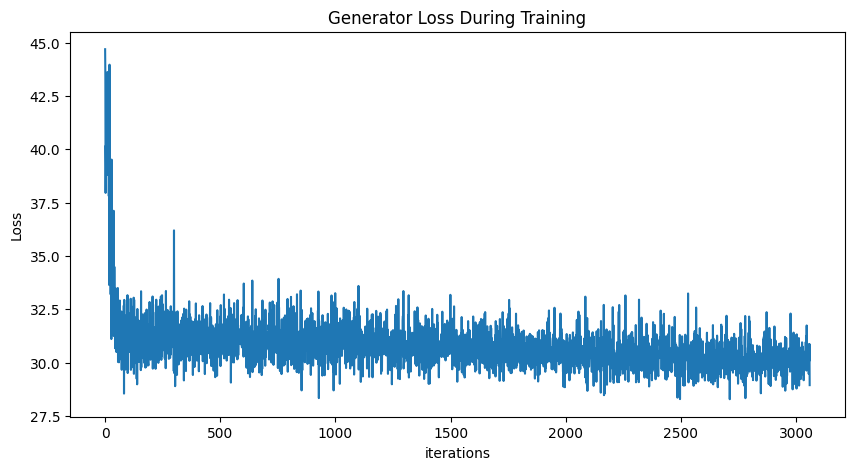

<Figure size 640x480 with 0 Axes>

In [21]:
# generator loss plot
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_generatorLoss_{}.png'.format(date)))

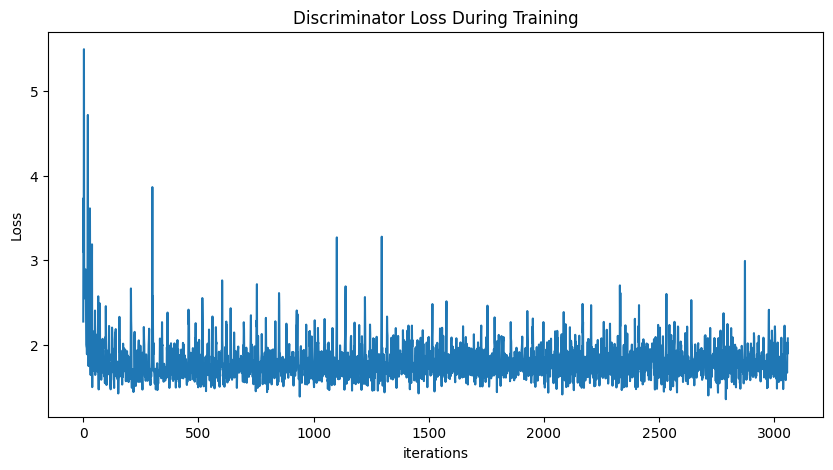

<Figure size 640x480 with 0 Axes>

In [22]:
# discriminator loss plot
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_discriminatorLoss_{}.png'.format(date)))

## Visualize output

In [23]:
# Get all file names from the "generated_images" directory
file_names = os.listdir(output_save_path)
file_names = [name for name in file_names if name.startswith('output_{}_'.format(date))]

# Sort the file names numerically
file_names = sorted(file_names, key=lambda name: int(name.split('_')[3].split('.')[0]))

# Create a list to store the read images
images = []

for file_name in file_names:
    images.append(imageio.imread(os.path.join(output_save_path,file_name)))

imageio.mimsave(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)), images, fps=1) 

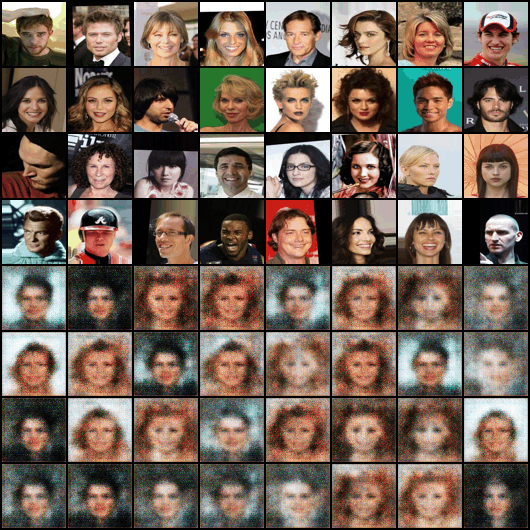

In [24]:
from IPython.display import Image

# Load the GIF
with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)),'rb') as file:
    display(Image(file.read()))